## Подготовка данных

Импортируем все нужные нам библиотеки:

In [ ]:
pip install Catboost

In [ ]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score,roc_curve,precision_score,recall_score
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score 
from sklearn.ensemble import RandomForestClassifier 
from catboost import CatBoostClassifier
import numpy as np

Прочитаем файл и сохраним его в переменной `data` и выведим первые 5 строк:

In [ ]:
data=pd.read_csv('__')

In [ ]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Согласно документации 14 столбцов:

* `RowNumber` — индекс строки в данных
* `CustomerId` — уникальный идентификатор клиента
* `Surname` — фамилия
* `CreditScore` — кредитный рейтинг
* `Geography` — страна проживания
* `Gender` — пол
* `Age` — возраст
* `Tenure` — сколько лет человек является клиентом банка
* `Balance` — баланс на счёте
* `NumOfProducts` — количество продуктов банка, используемых клиентом 
* `HasCrCard` — наличие кредитной карты
* `IsActiveMember` — активность клиента
* `EstimatedSalary` — предполагаемая зарплата

Выведим общую информацию о таблице:

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Приведем названия столбцов к нижнему и змеиному регистру:

In [ ]:
data.columns=['Row_Number', 'Customer_Id', 'Surname', 'Credit_Score', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'Num_Of_Products', 'Has_Cr_Card',
       'Is_Active_Member', 'Estimated_Salary', 'Exited']

In [ ]:
data.columns=data.columns.str.lower()

**Вывод**

Мы привели название столбцов к стандарту, а также обнаружили пропуски в столбце `tenure`. Далее посмотрим что с ними можно сделать.

### Пропуски в `tenure`

Посмотрим на строки, где пропущенно `tenure`:

In [ ]:
data[data['tenure'].isna()].head()

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
30,31,15589475,Azikiwe,591,Spain,Female,39,NaN,0.00,3,1,0,140469.38,1
48,49,15766205,Yin,550,Germany,Male,38,NaN,103391.38,1,0,1,90878.13,0
51,52,15768193,Trevisani,585,Germany,Male,36,NaN,146050.97,2,0,0,86424.57,0
53,54,15702298,Parkhill,655,Germany,Male,41,NaN,125561.97,1,0,0,164040.94,1
60,61,15651280,Hunter,742,Germany,Male,35,NaN,136857.00,1,0,0,84509.57,0


Предположим, что пропуски связанны с тем, что клиент новый.

Заменим значения на `0`:

In [ ]:
data['tenure']=data['tenure'].fillna(0)

**Вывод**

Мы предположили, что пропуски это новый клиент и заменили на значение `0`.

## Исследование задачи

Для нас важно сохранить клиента, поэтому нам предпочтительно наилучшое предсказания класса `1`. В рассматриваемых моделях будем ориентироваться на метрику `полнота`, так как нам важно, чтобы модель хорошо разобралась в особенностях этого класса и распознала его.

Перед тем, как начать тестировать модели, нам ниобхадимо преобразовать данные.

### One-Hot Encoding

Преобразуем категориальные признаки в численные методом прямого кодирования.

Отберем столбцы, которые будем кодировать:

In [ ]:
data_dum=data.drop(['surname','customer_id'],axis=1)

Для избижания дамми-ловушки, будем удалять первый преобразованный столбец:

In [ ]:
data_dum = pd.get_dummies(data_dum, drop_first=True)

Cоединим обратно таблицу:

In [ ]:
data_dum=data_dum.join(data[['surname','customer_id']]).reset_index(drop=True)
data

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


**Вывод**

Мы преобразовали категориальные признаки в численные методом OHE.

### Разабьем данные на выборки

Отдельной тестовой выборки у нас нет.Значит данные разабьем на три части: обучающую, валидационную и тестовую.

Разбиваем в отношении 3:1:1.

Поделим данные на целевой признак и признаки:

In [ ]:
target = data_dum['exited']
features = data_dum[['credit_score', 'age', 'tenure', 'balance',
                 'num_of_products', 
                 'has_cr_card', 'is_active_member',
                 'estimated_salary','geography_Germany', 'geography_Spain','gender_Male']]

Сначало разабьем данные на тестовую и остальные:

In [ ]:
features_train, features_valid_test, target_train, target_valid_test = train_test_split(
    features, target, test_size=0.40, random_state=12345)

Теперь разбиваем оставщуюся часть на валидационную и тестовую:

In [ ]:
features_test, features_valid, target_test, target_valid = train_test_split(
    features_valid_test, target_valid_test, test_size=0.50, random_state=12345)

Посмотрим на размеры получившихся выборок:

In [ ]:
print('Размер тренировочной выборки:',target_train.shape)
print('Размер валидационной выборки:',target_valid.shape)
print('Размер тестовой выборки:',target_test.shape)

Размер тренировочной выборки: (6000,)
Размер валидационной выборки: (2000,)
Размер тестовой выборки: (2000,)


**Вывод**

Мы разбили данные на три части : обучающую (60%), валидационную(20%) и тестовую(20%)

### Масштабирование

Для масштабирования будем использовать структуру `StandartScaler`, который стандартизирует данные:

Передадим все численные столбцы в переменную:

In [ ]:
numeric = ['credit_score', 'age','estimated_salary','tenure','balance']

Стандартизируем их

In [ ]:
scaler=StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

Посмотрим на преобразованную таблицу:

In [ ]:
features_train.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_Germany,geography_Spain,gender_Male
7479,-0.886751,-0.373192,1.104696,1.232271,1,1,0,-0.187705,0,1,1
3411,0.608663,-0.183385,1.104696,0.600563,1,0,0,-0.333945,0,0,0
6027,2.052152,0.480939,-0.503694,1.027098,2,0,1,1.503095,1,0,1
1247,-1.457915,-1.417129,0.461340,-1.233163,2,1,0,-1.071061,0,0,1
3716,0.130961,-1.132419,-0.825373,1.140475,1,0,0,1.524268,1,0,0


## Борьба с дисбалансом

В таблице наблюдается сильный дисбаланс нашей метрики:

In [ ]:
data['exited'].value_counts(normalize=True)

0    0.7963
1    0.2037
Name: exited, dtype: float64

Всего 20% данных с положительной метрикой.

Для борьбы с этой проблемой используем два метода.

Создадим функцию увеличения редкого класса:

In [ ]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

Посмотрим в каком отношении разбися целевой признак:

In [ ]:
target_upsampled.value_counts(normalize=True)

0    0.501043
1    0.498957
Name: exited, dtype: float64

Создадим функцию уменьшения частого класса:

In [ ]:

def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

Посмотрим в каком отношении разбися целевой признак:

In [ ]:
target_downsampled.value_counts(normalize=True)

0    0.501043
1    0.498957
Name: exited, dtype: float64

**Вывод**

Мы методом OHE закодировали категориальные признаки, затем разбили данные на обучающую, валидационную и тестовую (в соотношении 3:1:1).После этого стандартизировали все колличественные признаки.

Для борьбы с дисбалансом создали функции, которые увеличивает частоту редкого класса и уменьшает частый класс.

## Тестирование модели

Для упрощения дальнейшего исследования создадим функции для расчета метрик, которые нам нужны:

In [ ]:
def metrics(model,target,features,prediction):
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one = probabilities_valid[:, 1]
    auc_roc=roc_auc_score(target_valid,probabilities_one)
    
    return (
        print(" f1:", f1_score(target,prediction),'\n',"Точность:",
        precision_score(target,prediction),'\n',"Полнота:",
        recall_score(target,prediction),'\n',"Матрица ошибок:",
        confusion_matrix(target,prediction),"\n",'площадь под ROC-кривой:',
        auc_roc)
    )

Функция PR-кривой:

In [ ]:
def pr(model):
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    precision, recall, thresholds = precision_recall_curve(target_valid, probabilities_valid[:, 1])

    return (plt.figure(figsize=(6, 6)),
            plt.step(recall, precision, where='post'),
            plt.xlabel('Recall'),
            plt.ylabel('Precision'),
            plt.ylim([0.0, 1.05]),
            plt.xlim([0.0, 1.0]),
            plt.title('Кривая Precision-Recall'),
            plt.show(),
           )

Функция ROC-кривой:

In [ ]:
def roc(model):
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)# < напишите код здесь >
    return (plt.figure(),
            plt.plot([0, 1], [0, 1], linestyle='--'),
            plt.plot(fpr, tpr),
            plt.xlim([0.0, 1.0]),
            plt.ylim([0.0, 1.0]),
            plt.xlabel('False Positive Rate'),
            plt.ylabel('True Positive Rate'),
            plt.title('ROC-кривая'), 
            plt.show()
           ) 
    

### Логистическая регрессия

Создадим модель логистической регрессии:

In [ ]:
model=LogisticRegression(random_state=12345,solver='liblinear')

#### C уменьшенной выборкой

Обучим модель на данных с уменьшенной выборкой:

In [ ]:
model.fit(features_downsampled,target_downsampled)
predicted_valid=model.predict(features_valid)

Выведим интересующие нас метрики:

In [ ]:
metrics(model,target_valid, features_valid,predicted_valid)

 f1: 0.485885372112917 
 Точность: 0.3806970509383378 
 Полнота: 0.6713947990543735 
 Матрица ошибок: [[1115  462]
 [ 139  284]] 
 площадь под ROC-кривой: 0.7413153922146218


Построим PR-кривую:

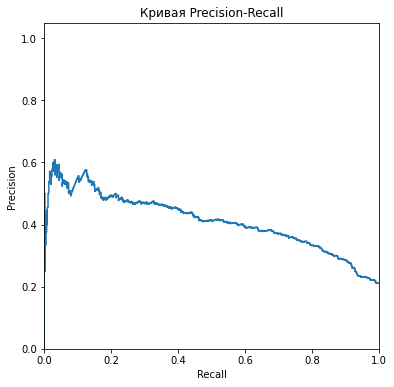

(<Figure size 432x432 with 1 Axes>,
 Text(0.5, 17.200000000000003, 'Recall'),
 Text(17.200000000000003, 0.5, 'Precision'),
 (0.0, 1.05),
 (0.0, 1.0),
 Text(0.5, 1.0, 'Кривая Precision-Recall'),
 None)

In [ ]:
pr(model)

Построим ROC-кривую:

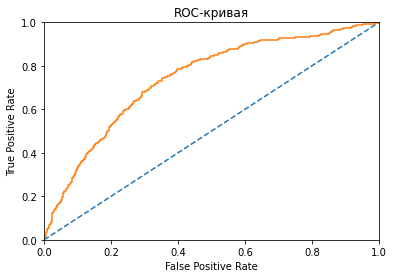

(<Figure size 432x288 with 1 Axes>,
 (0.0, 1.0),
 (0.0, 1.0),
 Text(0.5, 17.200000000000003, 'False Positive Rate'),
 Text(17.200000000000003, 0.5, 'True Positive Rate'),
 Text(0.5, 1.0, 'ROC-кривая'),
 None)

In [ ]:
roc(model)

#### C увеличенной выборкой

Теперь обучим модель на данных с увеличенной выборкой:

In [ ]:
model.fit(features_upsampled, target_upsampled)
predicted_valid=model.predict(features_valid)

Выведим интересующие нас метрики:

In [ ]:
metrics(model,target_valid, features_valid,predicted_valid)

 f1: 0.4779220779220779 
 Точность: 0.3770491803278688 
 Полнота: 0.6524822695035462 
 Матрица ошибок: [[1121  456]
 [ 147  276]] 
 площадь под ROC-кривой: 0.7416631812805534


Построим PR-кривую:

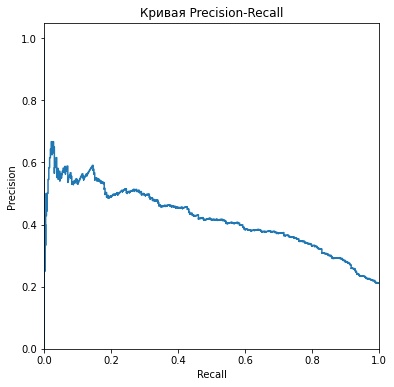

(<Figure size 432x432 with 1 Axes>,
 Text(0.5, 17.200000000000003, 'Recall'),
 Text(17.200000000000003, 0.5, 'Precision'),
 (0.0, 1.05),
 (0.0, 1.0),
 Text(0.5, 1.0, 'Кривая Precision-Recall'),
 None)

In [ ]:
pr(model)

Построим ROC-кривую:

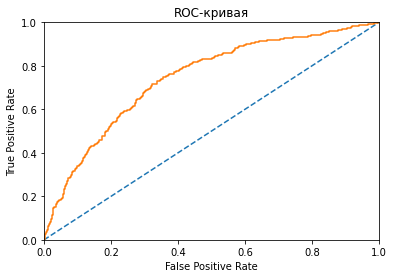

(<Figure size 432x288 with 1 Axes>,
 (0.0, 1.0),
 (0.0, 1.0),
 Text(0.5, 17.200000000000003, 'False Positive Rate'),
 Text(17.200000000000003, 0.5, 'True Positive Rate'),
 Text(0.5, 1.0, 'ROC-кривая'),
 None)

In [ ]:
roc(model)

####  без изменения выборки

Теперь обучим модель на данных с оригинальной выборокой.

Только в моделе логистической регрессии укажем в весе класса - сбалансированный:

In [ ]:
model=LogisticRegression(random_state=12345,solver='liblinear',class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid=model.predict(features_valid)

Выведим интересующие нас метрики:

In [ ]:
metrics(model,target_valid, features_valid,predicted_valid)

 f1: 0.4797238999137188 
 Точность: 0.37771739130434784 
 Полнота: 0.6572104018912529 
 Матрица ошибок: [[1119  458]
 [ 145  278]] 
 площадь под ROC-кривой: 0.7417051558229933


In [ ]:
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc=roc_auc_score(target_valid,probabilities_one_valid)
print(auc_roc)

0.7417051558229933


Построим PR-кривую:

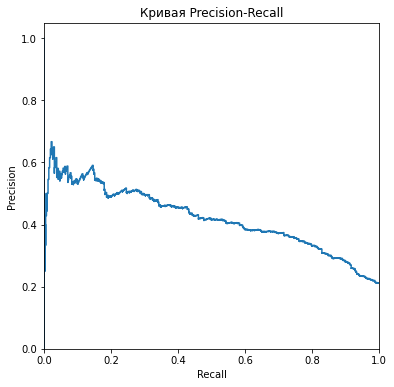

(<Figure size 432x432 with 1 Axes>,
 Text(0.5, 17.200000000000003, 'Recall'),
 Text(17.200000000000003, 0.5, 'Precision'),
 (0.0, 1.05),
 (0.0, 1.0),
 Text(0.5, 1.0, 'Кривая Precision-Recall'),
 None)

In [ ]:
pr(model)

Построим ROC-кривую:

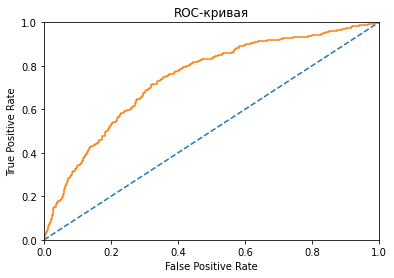

(<Figure size 432x288 with 1 Axes>,
 (0.0, 1.0),
 (0.0, 1.0),
 Text(0.5, 17.200000000000003, 'False Positive Rate'),
 Text(17.200000000000003, 0.5, 'True Positive Rate'),
 Text(0.5, 1.0, 'ROC-кривая'),
 None)

In [ ]:
roc(model)

#### Без учета дисбаланса 

Теперь обучим без какого-либо баланса

In [ ]:
model=LogisticRegression(random_state=12345,solver='liblinear')
model.fit(features_train, target_train)
predicted_valid=model.predict(features_valid)

Посмотрим на получившиеся метрики:

In [ ]:
metrics(model,target_valid, features_valid,predicted_valid)

 f1: 0.2743055555555555 
 Точность: 0.5163398692810458 
 Полнота: 0.1867612293144208 
 Матрица ошибок: [[1503   74]
 [ 344   79]] 
 площадь под ROC-кривой: 0.738820905121044


**Вывод**

Наибольшая f1-мера  и полнота была достигнута на уменьшенной выборке(`48.6% и 67.1%`).

Заметно как отсутствие баланса влияет на f1. Она становиться катастрофически маленькой(происходит из-за полноты). Всего 27.4% вместо 48.6%. А полнота 18.7% против  67.1%. Модель катострафически не может правильно определять 1 класс.

К последующим моделям будем применять данные с уменьшенной выборкой.

### Дерево решений

Обучим модель на обучающихся данных.

Чтобы определить наилучший `f1`, в цикле переберем гиперпараметр `max_depth`:

In [ ]:
best_model_DecisionTree = None
best_predicted_valid=None
best_result = 0
best_depth=0
for index in range(1,10):
    model=DecisionTreeClassifier(random_state=12345,max_depth=index)
    model.fit(features_downsampled, target_downsampled)
    predicted_valid=model.predict(features_valid)
    #result=model.score(features_valid,target_valid)
    result=f1_score(target_valid,predicted_valid)
    if result > best_result:
        best_predicted_valid=predicted_valid
        best_model_DecisionTree = model
        best_result = result
        best_depth = index
print("F1 наилучшей модели на валидационной выборке:", best_result)
print("Наилучшая глубина дерева на валидационной выборке:", best_depth)

F1 наилучшей модели на валидационной выборке: 0.6074380165289257
Наилучшая глубина дерева на валидационной выборке: 5


Выведим интересующие нас метрики:

In [ ]:
metrics(best_model_DecisionTree,target_valid, features_valid,best_predicted_valid)

 f1: 0.6074380165289257 
 Точность: 0.5394495412844037 
 Полнота: 0.6950354609929078 
 Матрица ошибок: [[1326  251]
 [ 129  294]] 
 площадь под ROC-кривой: 0.8371844976022043


Построим PR-кривую:

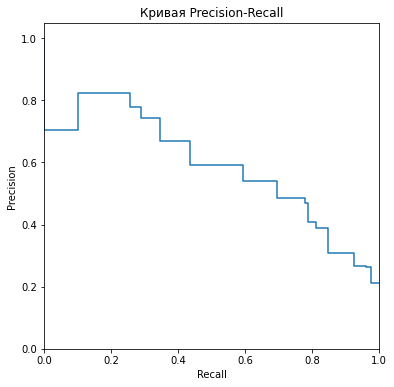

(<Figure size 432x432 with 1 Axes>,
 Text(0.5, 17.200000000000003, 'Recall'),
 Text(17.200000000000003, 0.5, 'Precision'),
 (0.0, 1.05),
 (0.0, 1.0),
 Text(0.5, 1.0, 'Кривая Precision-Recall'),
 None)

In [ ]:
pr(best_model_DecisionTree)

Построим ROC-кривую:

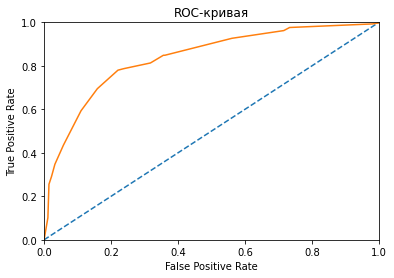

(<Figure size 432x288 with 1 Axes>,
 (0.0, 1.0),
 (0.0, 1.0),
 Text(0.5, 17.200000000000003, 'False Positive Rate'),
 Text(17.200000000000003, 0.5, 'True Positive Rate'),
 Text(0.5, 1.0, 'ROC-кривая'),
 None)

In [ ]:
roc(best_model_DecisionTree)

### Случайный лес

Чтобы получить наилучшую метрику качества, в цикле переберем колличество деревьев(`n_estimators`) и глубину дерева(`max_depth`):

In [ ]:
%%time

best_model_RandomForest = None
best_result = 0
best_depth=0
best_est=0
predicted_valid=None
for est in range(1, 20):
    for depth in range (1, 10):       
        model = RandomForestClassifier(random_state=12345, n_estimators=est,max_depth=depth) 
        model.fit(features_downsampled,target_downsampled) 
        predicted_valid=model.predict(features_valid)
        #result=model.score(features_valid,target_valid)
        result=f1_score(target_valid,predicted_valid)
        if result > best_result:
            best_predicted_valid=predicted_valid
            best_model_RandomForest = model
            best_result = result
            best_depth = depth
            best_est = est

print("F1 наилучшей модели на валидационной выборке:", best_result)
print("Наилучшая глубина дерева на валидационной выборке:", best_depth)
print("Наилучшее колличество деревьев на валидационной выборке:", best_est)

F1 наилучшей модели на валидационной выборке: 0.5913875598086125
Наилучшая глубина дерева на валидационной выборке: 7
Наилучшее колличество деревьев на валидационной выборке: 11
CPU times: user 9.19 s, sys: 34.4 ms, total: 9.22 s
Wall time: 11.1 s


Выведим интересующие нас метрики:

In [ ]:
metrics(best_model_RandomForest,target_valid, features_valid,best_predicted_valid)

 f1: 0.5913875598086125 
 Точность: 0.4967845659163987 
 Полнота: 0.7304964539007093 
 Матрица ошибок: [[1264  313]
 [ 114  309]] 
 площадь под ROC-кривой: 0.8434814285136065


Построим PR-кривую:

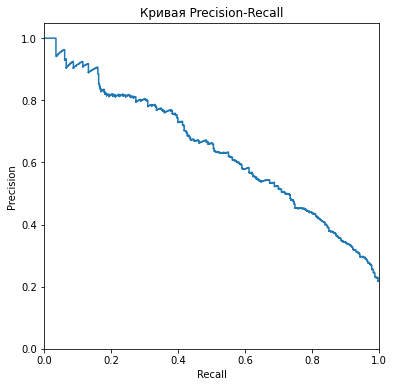

(<Figure size 432x432 with 1 Axes>,
 Text(0.5, 17.200000000000003, 'Recall'),
 Text(17.200000000000003, 0.5, 'Precision'),
 (0.0, 1.05),
 (0.0, 1.0),
 Text(0.5, 1.0, 'Кривая Precision-Recall'),
 None)

In [ ]:
pr(best_model_RandomForest)

Построим ROC-кривую:

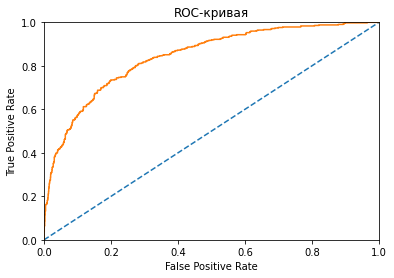

(<Figure size 432x288 with 1 Axes>,
 (0.0, 1.0),
 (0.0, 1.0),
 Text(0.5, 17.200000000000003, 'False Positive Rate'),
 Text(17.200000000000003, 0.5, 'True Positive Rate'),
 Text(0.5, 1.0, 'ROC-кривая'),
 None)

In [ ]:
roc(best_model_RandomForest)

### Сatboost

Для кэтбуста наилучший результат выдает увеличенная выборка.

Создадим модель градиентного бустинга:

In [ ]:
model=CatBoostClassifier(verbose=100,early_stopping_rounds=200)

In [ ]:
model.fit(features_upsampled, target_upsampled,eval_set=(features_valid,target_valid))
predicted_valid=model.predict(features_valid)

Learning rate set to 0.055385
0:	learn: 0.6615881	test: 0.6649280	best: 0.6649280 (0)	total: 55.2ms	remaining: 55.1s
100:	learn: 0.3923342	test: 0.4306225	best: 0.4306225 (100)	total: 1.02s	remaining: 9.08s
200:	learn: 0.3396933	test: 0.4180967	best: 0.4180967 (200)	total: 2.17s	remaining: 8.64s
300:	learn: 0.2993873	test: 0.4109927	best: 0.4109927 (300)	total: 3.34s	remaining: 7.76s
400:	learn: 0.2665956	test: 0.4060194	best: 0.4060194 (400)	total: 4.63s	remaining: 6.92s
500:	learn: 0.2362305	test: 0.4008633	best: 0.4008200 (499)	total: 5.55s	remaining: 5.53s
600:	learn: 0.2116555	test: 0.3973169	best: 0.3971230 (582)	total: 6.74s	remaining: 4.47s
700:	learn: 0.1911006	test: 0.3952523	best: 0.3951902 (698)	total: 8.05s	remaining: 3.43s
800:	learn: 0.1728871	test: 0.3929422	best: 0.3926480 (794)	total: 9.04s	remaining: 2.25s
900:	learn: 0.1569180	test: 0.3917526	best: 0.3917526 (900)	total: 9.86s	remaining: 1.08s
999:	learn: 0.1426650	test: 0.3919893	best: 0.3911269 (933)	total: 10.6s	

Выведим интересующие нас метрики:

In [ ]:
metrics(model,target_valid, features_valid,predicted_valid)

 f1: 0.6118192352259559 
 Точность: 0.6 
 Полнота: 0.624113475177305 
 Матрица ошибок: [[1401  176]
 [ 159  264]] 
 площадь под ROC-кривой: 0.8513561524935127


Построим PR-кривую:

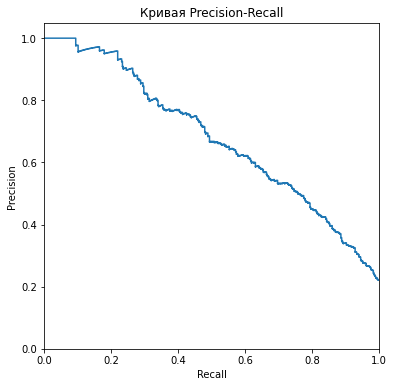

(<Figure size 432x432 with 1 Axes>,
 Text(0.5, 17.200000000000003, 'Recall'),
 Text(17.200000000000003, 0.5, 'Precision'),
 (0.0, 1.05),
 (0.0, 1.0),
 Text(0.5, 1.0, 'Кривая Precision-Recall'),
 None)

In [ ]:
pr(model)

Построим ROC-кривую:

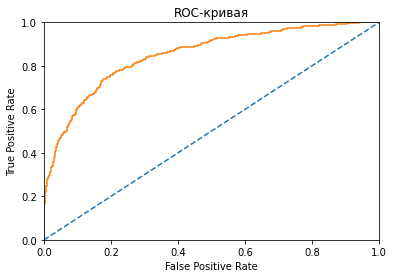

(<Figure size 432x288 with 1 Axes>,
 (0.0, 1.0),
 (0.0, 1.0),
 Text(0.5, 17.200000000000003, 'False Positive Rate'),
 Text(17.200000000000003, 0.5, 'True Positive Rate'),
 Text(0.5, 1.0, 'ROC-кривая'),
 None)

In [ ]:
roc(model)

**Вывод**

Наилучшей параметр `полнота` достигается в модели случайного леса(`73%`). А `f1` метрика в дерево решений (`60.7%`).

Наибольшая площадь ROC-кривой достигается в Catboost (`85.1%`)

## Проверка модели на тестовой выборке

В качестве основной модели я возьму `Случайный лес`, так как полнота наивысшая.

In [ ]:
predictions = best_model_DecisionTree.predict(features_test)
f1=f1_score(target_test,predictions)
recall=recall_score(target_test,predictions)
print("f1 на тестовой выборке:", f1)
print("полнота на тестовой выборке:", recall)

f1 на тестовой выборке: 0.5931174089068827
полнота на тестовой выборке: 0.7009569377990431


Посмотрим на матрицу ошибок:

In [ ]:
confusion_matrix(target_test,predictions)

array([[1305,  277],
       [ 125,  293]])

### Манипуляции с порогом

Так как AUC-ROC наибольший у `Catboost`, то поэксперементируем с порогом в этой модели.

Добавим в  основную тестовую таблицу столбцы, где указана вероятность присвоени класса `1` (`score`) и столбец предскозания значения (`prediction`).

In [ ]:
probabilities_valid = model.predict_proba(features_test)
probabilities_one_test = probabilities_valid[:, 1]

In [ ]:
data_predict_score = data.merge(target_test,how='right',
           left_index=True,
           right_index=True).drop('exited_x',axis=1).join(pd.DataFrame
                                                 ({'score': probabilities_one_test,'prediction': predictions},
                                                  index=target_test.index))


In [ ]:
data_predict_score.head()

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited_y,score,prediction
8532,8533,15780805,Lu,585,France,Female,35,2.0,0.00,2,1,0,98621.04,1,0.033688,0
5799,5800,15649853,Craig,625,France,Female,45,3.0,0.00,1,1,1,184474.15,1,0.708747,1
5511,5512,15714970,Holbrook,667,Germany,Male,32,0.0,103846.65,1,1,0,20560.69,0,0.268979,1
7365,7366,15593178,Graham,568,Spain,Female,36,10.0,153610.61,1,1,1,54083.80,1,0.016206,0
7367,7368,15736399,Korovin,606,Spain,Male,42,10.0,0.00,2,1,0,177938.52,0,0.027651,0


Теперь добавим новый столбец с предсказанием, при пороге `0.3`:

In [ ]:
data_predict_score['prediction_new']=(data_predict_score['score'] > 0.18)*1

Посмотрим на матрицу ошибок с измененым порогом:

In [ ]:
confusion_matrix(target_test,np.asarray(data_predict_score['prediction_new']))

array([[1050,  532],
       [  75,  343]])

Достигнутая полнота:

In [ ]:
recall_score(target_test,np.asarray(data_predict_score['prediction_new']))

0.8205741626794258

Дополнительно взглянем, какие параметры больше всего влияют на модель предсказания:

In [ ]:
pd.DataFrame({'fi':model.feature_importances_,
              'feature': features}).sort_values('fi',ascending=False)

,fi,feature
1,18.021153,"(a, g, e)"
7,14.796366,"(e, s, t, i, m, a, t, e, d, _, s, a, l, a, r, y)"
3,14.686112,"(b, a, l, a, n, c, e)"
0,14.597690,"(c, r, e, d, i, t, _, s, c, o, r, e)"
4,13.918629,"(n, u, m, _, o, f, _, p, r, o, d, u, c, t, s)"
2,7.371735,"(t, e, n, u, r, e)"
6,5.497574,"(i, s, _, a, c, t, i, v, e, _, m, e, m, b, e, r)"
8,4.562742,"(g, e, o, g, r, a, p, h, y, _, G, e, r, m, a, ..."
10,2.940738,"(g, e, n, d, e, r, _, M, a, l, e)"
9,1.904336,"(g, e, o, g, r, a, p, h, y, _, S, p, a, i, n)"


**Вывод**

Был проведен исследования данных в результате которого методом OHE категориальные признаки были закодированы. Также колличественные признаки были стандартизированы. 

Был проведен анализ дисбаланса в результате которого выяснили, что лучшие качества метрики наблюдаеются у таблицы с уменьшением частого класса.

В ходе тестирования модели я ориентировался на `полноту`, так как нам больше всего важно не упустить клиента.
Лучше всего показала себя модель `Случайного леса`(`recall = 70.3`)

Для изменения порога я использовал `Catboost`, так как площадь AUC-ROC наибольшая. При изменении порога на `0.18` полната составила `80.8%`